First, import some useful packages and set everything up.

In [1]:
%matplotlib inline
!pip install datasets  # You can install custom packages on Google Colab by !pip install ...
!pip install transformers

import copy
import datasets
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas
import random
import seaborn

from collections import Counter
from transformers import BertTokenizer, RobertaTokenizer

# For reproducibility, fix random seeds.
random.seed(42)
np.random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.7 MB/s eta 0:00:00


# Data

Let's start with loading the [AG News dataset](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html). A [version of AG](https://huggingface.co/datasets/viewer/?dataset=ag_news) is made easily available by huggingface, so we will use that. Since this dataset comes in only a train-test split, we will create a validation set by setting aside a random subset of the training portion.

In [2]:
dataset = datasets.load_dataset('ag_news')
label2str = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}  # Integer-string mapping for labels

splitted = dataset['train'].train_test_split(test_size=0.1)  # Shuffles by default before splitting.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Check what the data looks like.

In [3]:
train_docs = splitted['train']['text']
train_labels = splitted['train']['label']
val_docs = splitted['test']['text']
val_labels = splitted['test']['label']
test_docs = dataset['test']['text']
test_labels = dataset['test']['label']

print('{} training documents'.format(len(train_docs)))
print('{} validation documents'.format(len(val_docs)))
print('{} test documents\n'.format(len(test_docs)))
print('Labels\n', label2str)
print(train_docs[42])  # Show a random example
print(train_labels[42], label2str[train_labels[42]])

108000 training documents
12000 validation documents
7600 test documents

Labels
 {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
Nov Retail Sales Edge Up as Car Sales Dip  WASHINGTON (Reuters) - U.S. retail sales rose 0.1 percent  in November, the Commerce Department said on Monday in a  stronger-than-expected report that cemented views the Federal  Reserve will raise interest rates again this week.
2 Business


Let's define a Tokenizer class to help us tokenize text easily and get n-gram statistics.

In [4]:
class Tokenizer:

  def __init__(self, tokenize_type='basic', lowercase=False):
    self.tokenize_type = tokenize_type
    self.lowercase = lowercase

    if self.tokenize_type == 'wp':
      self.wptok = BertTokenizer.from_pretrained('bert-base-cased')

  def tokenize(self, string):
    if self.lowercase:
      string = string.lower()

    if self.tokenize_type == 'basic':
      tokens = string.split()
    elif self.tokenize_type == 'nltk':
      tokens = nltk.tokenize.word_tokenize(string)
    elif self.tokenize_type == 'wp':
      tokens = self.wptok.tokenize(string)
    else:
      raise ValueError('Unknown tokenization type.')

    return tokens

  def count_ngrams(self, toks, n=3):
    ngram_counts = [Counter() for _ in range(n)]

    for i in range(len(toks)):
      for j in range(n):
        if i - j >= 0:
          ngram = tuple([toks[k] for k in range(i - j, i + 1)])
          ngram_counts[j][ngram] += 1

    return ngram_counts


def show_ngram_information(ngram_counts, k, quiet=False):
  topk_unigrams = ngram_counts[0].most_common(k)
  topk_bigrams = ngram_counts[1].most_common(k)
  topk_trigrams = ngram_counts[2].most_common(k)

  if not quiet:
    print('-' * 79)
    print('Most frequent n-grams for n=1,2,3')
    for i in range(k):
      if i < len(ngram_counts[0]):
        print('{:10s} {:12d}\t\t'.format(' '.join(topk_unigrams[i][0]), topk_unigrams[i][1]), end='')
        print('{:20s} {:12d}\t\t'.format(' '.join(topk_bigrams[i][0]), topk_bigrams[i][1]), end='')
        print('{:22s} {:12d}'.format(' '.join(topk_trigrams[i][0]), topk_trigrams[i][1]))

  plt.figure(figsize=(20,5))
  labels, y = zip(*ngram_counts[0].most_common(50))
  zipf = [y[0]/i for i in range(1, len(y) + 1)]
  labels = [label_[0] for label_ in labels]
  plt.plot(labels, y, '-r', label='Frequency', linewidth=1)
  plt.plot(labels, zipf, '-b', label='Zipf', linewidth=1)
  plt.xticks(rotation=90)
  plt.legend(loc="upper right")
  plt.show()

Let's tokenize and check the Zipf's law on a portion of the training data. Feel free to explore different tokenizers, but for later parts we will assume nltk tokenization for better readability.

We need to download punkt package. Select Download (d) and specify "punkt" for Identifier below.
```
NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt
    Downloading package punkt to /root/nltk_data...
      Unzipping tokenizers/punkt.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q
```

In [5]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt


      Unzipping tokenizers/punkt.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [6]:
tokenize_type='nltk'
tokenizer = Tokenizer(tokenize_type=tokenize_type, lowercase=True)

train_toks = [tokenizer.tokenize(doc) for doc in train_docs]
val_toks = [tokenizer.tokenize(doc) for doc in val_docs]
test_toks = [tokenizer.tokenize(doc) for doc in test_docs]

train_ngram_counts = tokenizer.count_ngrams(list(itertools.chain(*train_toks)))

print('{} tokens in training under tokenizer type {}\n{}/{}/{} unique unigram/bigram/trigram types'.format(
    len(train_toks), tokenize_type, len(train_ngram_counts[0]), len(train_ngram_counts[1]),
    len(train_ngram_counts[2])))

108000 tokens in training under tokenizer type nltk
95100/1167717/2708525 unique unigram/bigram/trigram types


-------------------------------------------------------------------------------
Most frequent n-grams for n=1,2,3
the              183612		# 39                        39831		# 39 ;                        39831
,                144983		39 ;                        39831		39 ; s                        28038
.                120211		; s                         28167		& gt ;                        11769
to               107187		in the                      19187		& lt ;                        11764
a                 98957		of the                      18324		( reuters )                   11543
of                88202		, the                       12187		reuters ) -                    7743
in                85923		gt ;                        11817		( ap )                         7443
;                 78415		lt ;                        11769		ap ) ap                        6921
and               62035		& gt                        11769		) ap -                         6921
on                5081

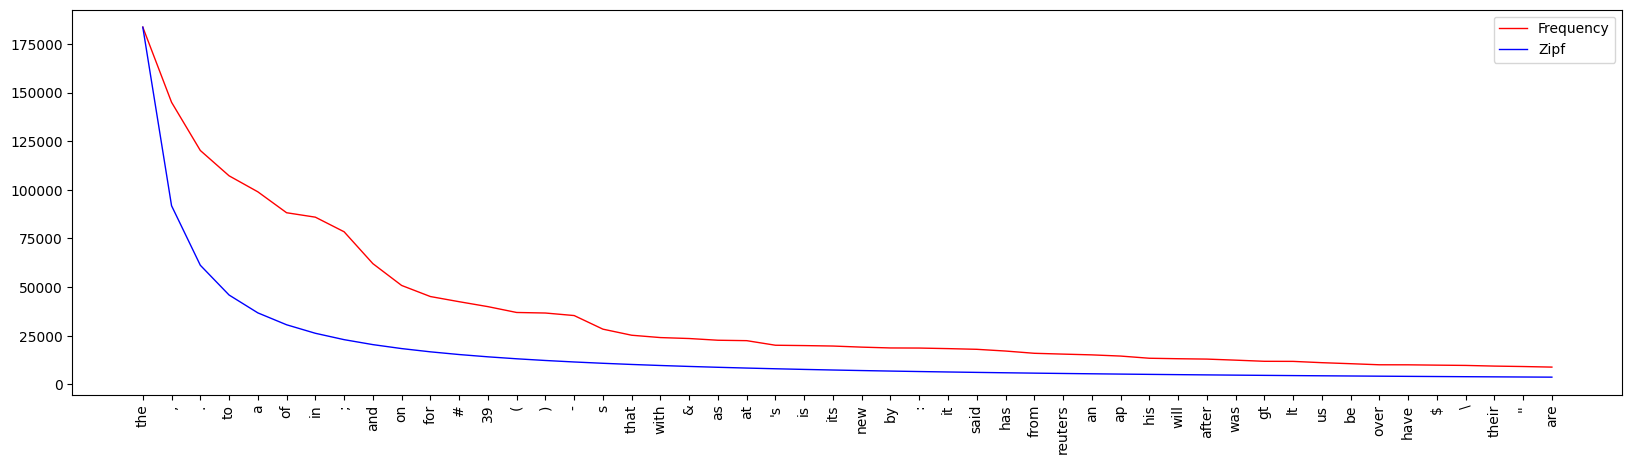

In [7]:
show_ngram_information(train_ngram_counts, 10)

Given the choice of tokenization, now is the time to choose *representation*. A common practice in NLP is to use the vocabulary (i.e., unique token/word types) as basic units. For efficiency we will use the top-k most frequent words as our vocab. Then we apply this vocab to all our data.

In [8]:
vocab_size = 5000
vocab = [tup[0] for tup, _ in train_ngram_counts[0].most_common(vocab_size)]

#  vocab[i] can be accessed efficiently (it's a list), but we need a dictionary to map token to index efficiently.
w2i = {}
for i, word in enumerate(vocab):
  w2i[word] = i

# Threshold, then "bag" words (aka. bag-of-words representation).
train_inds = [set([w2i[tok] for tok in toks if tok in w2i]) for toks in train_toks]
val_inds = [set([w2i[tok] for tok in toks if tok in w2i]) for toks in val_toks]
test_inds = [set([w2i[tok] for tok in toks if tok in w2i]) for toks in test_toks]

print(train_inds[0])  # Now each document is a non-linguistic set of integers in {0...vocab_size-1}.

{0, 1, 3457, 3, 4, 5, 6, 3458, 8, 2, 13, 14, 15, 530, 2963, 155, 2973, 32, 37, 294, 4017, 54, 321, 451, 839, 78, 224, 993, 870, 372, 2678, 631}


Finally, we will pack data into matrix/vector form. This is important for computational efficiency (to avoid for loops).

In [9]:
def get_matrix_form(docs, labels):
  assert len(docs) == len(labels)
  X = np.zeros((len(docs), vocab_size))
  y = np.zeros((len(docs), 1)).astype(int)
  for i, doc in enumerate(docs):
    for ind in doc:
      X[i, ind] = 1
    y[i] = labels[i]
  return X, y

X_train, y_train = get_matrix_form(train_inds, train_labels)
X_val, y_val = get_matrix_form(val_inds, val_labels)
X_test, y_test = get_matrix_form(test_inds, test_labels)

print('X_train: {}'.format(X_train.shape))
print('X_val: {}'.format(X_val.shape))
print('X_test: {}'.format(X_test.shape))

X_train: (108000, 5000)
X_val: (12000, 5000)
X_test: (7600, 5000)


Now we're ready to train a classifier! A couple of remarks before we proceed.

First, note that the binary vector representation of documents is very sparse and can be much more efficiently stored and worked with as dictionaries. For a long time NLP has worked with such sparse representations and there was a heavy emphasis on the use of hash tables. But as we will soon see, this is no longer the case, so we'll not bother and work directly with matrices even though they're memory-inefficient for such sparse representations.

Second, we stored *all* training data as a single matrix. This is not feasible if the data is large (e.g., the internet). If the data is large, we would load from a file corresponding to a portion of data one at a time as we plow through data during training.

# Model

Define a row-wise softmax that turns any rows of label scores (aka. "logits") into probability distributions over labels, with a numerical stability trick.

In [10]:
def softmax(scores):
  nonnegs = np.exp(scores - np.amax(scores, axis=1)[:, np.newaxis])
  return nonnegs / np.sum(nonnegs, axis=1)[:, np.newaxis]

Define a row-wise logsumexp that computes the log of the sum of the elements of each row, with a numerical stability trick.

In [11]:
def logsumexp(scores):
  rowwise_max = np.amax(scores, axis=1)[:, np.newaxis]
  return rowwise_max + np.log(np.sum(np.exp(scores - rowwise_max), axis=1)[:, np.newaxis])

We will learn a simple linear classifier. It will have two key functions:

- `forward`: Given $N$ documents it computes scores/logits for all $K=4$ labels, which you can represent as an $N \times K$ matrix. This is all you need to make inference (you just pick argmax), but if it's additionally given gold labels it will also compute the *sum* of per-example cross-entropy losses,
$$
- \sum_{i=1}^N \log \frac{\exp(w_{y_i}^\top x_i)}{\sum_{y=1}^K \exp(w_y^\top x_i)}
$$
which will only be used for monitoring purposes later. More importantly, it will call the next function to calculate gradients.

- `accumulate_gradients`: Given $N$ documents and gold labels and model scores, it computes the gradients of the *average* cross-entropy loss,
$$
\hat{J}(W, b) = - \frac{1}{N} \sum_{i=1}^N \log \frac{\exp(w_{y_i}^\top x_i)}{\sum_{y=1}^K \exp(w_y^\top x_i)}
$$
with respect to variables $W, b$ evaluated at the *current* values of $W, b$, then accumulates them for gradient-based optimization later.

In [12]:
class LinearClassifier:

  def __init__(self, dim, num_labels, init_range=0.1):
    self.W = np.random.uniform(-init_range, init_range, (dim, num_labels))
    self.b = np.zeros((1, num_labels))

    self.W_grad = np.zeros((dim, num_labels))
    self.b_grad = np.zeros((1, num_labels))

  def forward(self, X, y=None):
    batch_size = X.shape[0]
    scores = np.matmul(X, self.W) + np.tile(self.b, (batch_size, 1))  # (batch_size, num_labels)
    loss_sum = None
    if y is not None:  # We're given gold labels, we're training.
      loss_sum = np.sum(logsumexp(scores) - np.take_along_axis(scores, y, axis=1))
      self.accumulate_gradients(X, y, scores)

    return loss_sum, scores

  def accumulate_gradients(self, X, y, scores):
    batch_size = X.shape[0]
    num_labels = scores.shape[1]
    probs = softmax(scores)
    golds = np.zeros((batch_size, num_labels))
    golds[np.arange(batch_size), y[:,0]] = 1
    diffs = probs - golds

    # Taking the partial derivative of the cross-entropy loss w.r.t. weights W gives us X^T * (P(Y|X) - Y),
    # where P(Y|X) is the predicted probability distribution (probs) and Y is the one-hot encoded true labels (golds).
    # Averaging the gradient over the batch size to normalize its magnitude, making it consistent regardless of the number of samples in the batch
    self.W_grad += np.dot(X.T, diffs) / batch_size

    # Taking the partial derivative of the cross-entropy loss w.r.t. bias b gives us sum(P(Y|X) - Y) over the batch,
    # Summation is done across the batch (axis 0), aggregating the error contribution of each sample to the bias.
    self.b_grad += np.sum(diffs, axis = 0) / batch_size

  def zero_grad(self):
    self.W_grad.fill(0.)
    self.b_grad.fill(0.)

  def num_parameters(self):
    return self.W.size + self.b.size

One useful way to ensure that your gradient computation is absolutely correct is to do what's called the **gradient check**. The derivative of a function $f$ of some scalar variable $x \in \mathbb{R}$ evaluated at $x = a$ is:

$$
f'(a) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x - \epsilon)}{2\epsilon}
$$

(Aside: This two-sided formulation is much more accurate than the one-sided formulation $f'(a) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{\epsilon}$, see [this note](https://cs231n.github.io/neural-networks-3/#gradcheck).)
Thus we can set some small $\epsilon > 0$ and check if this is indeed the case for our gradients. Remember, in our case the function of interest is the *average cross entropy loss* defined on a single batch of labeled examples. We are calculating the gradient of that function with respect to model parameters $W, b$. Even though these are matrix-/vector-valued, a gradient is simply an array of partial derivatives so we can check each derivative individually.

In [13]:
import unittest
import copy

class TestGradient(unittest.TestCase):

  def setUp(self):
    np.random.seed(42)
    vocab_size = 100
    num_labels = 4
    num_examples = 20
    self.epsilon = 1e-4
    self.error_tolerance = 1e-6

    # Randomly initialized model
    self.model = LinearClassifier(vocab_size, num_labels)

    # Random inputs and labels
    self.X = np.random.randn(num_examples, vocab_size)
    self.y = np.random.randint(num_labels, size=(num_examples, 1))

    # Save the gradients from the model.
    self.model.forward(self.X, self.y)  # This triggers accumulate_gradients
    self.W_grad = copy.deepcopy(self.model.W_grad)
    self.b_grad = copy.deepcopy(self.model.b_grad)

  def test_gradient_W(self):
    for i in range(self.model.W.shape[0]):
      for j in range(self.model.W.shape[1]):
        # f(x + epsilon)
        self.model.W[i, j] += self.epsilon
        loss_avg_perturbed1 = self.model.forward(self.X, self.y)[0] / self.X.shape[0]

        # f(x - epsilon)
        self.model.W[i, j] -= 2 * self.epsilon
        loss_avg_perturbed2 = self.model.forward(self.X, self.y)[0] / self.X.shape[0]

        # Numerical approximation of the partial derivative
        truth = (loss_avg_perturbed1 - loss_avg_perturbed2) / (2 * self.epsilon)

        # Compute the relative error
        error = abs(self.W_grad[i, j] - truth) / max(abs(self.W_grad[i, j]), abs(truth))

        self.assertLess(error, self.error_tolerance)

        # Restore the original parameter value
        self.model.W[i, j] += self.epsilon

  def test_gradient_b(self):
    for i in range(self.model.b.shape[1]):
      # f(x + epsilon)
      self.model.b[0, i] += self.epsilon
      loss_avg_perturbed1 = self.model.forward(self.X, self.y)[0] / self.X.shape[0]

      # f(x - epsilon)
      self.model.b[0, i] -= 2 * self.epsilon
      loss_avg_perturbed2 = self.model.forward(self.X, self.y)[0] / self.X.shape[0]

      # Numerical approximation of the partial derivative
      truth = (loss_avg_perturbed1 - loss_avg_perturbed2) / (2 * self.epsilon)

      # Compute the relative error
      error = abs(self.b_grad[0, i] - truth) / max(abs(self.b_grad[0, i]), abs(truth))

      self.assertLess(error, self.error_tolerance)

      # Restore the original parameter value
      self.model.b[0, i] += self.epsilon


unittest.main(TestGradient(), argv=[''], verbosity=2, exit=False)

test_gradient_W (__main__.TestGradient) ... ok
test_gradient_b (__main__.TestGradient) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.111s

OK


# Training

We will use stochastic gradient descent (SGD) to optimize the average cross-entropy loss above. Define a simple SGD optimizer class, which updates parameters of the associated model.

In [14]:
class SGDOptimizer:

  def __init__(self, model, learning_rate):
    self.model = model
    self.lr = learning_rate

  # Updating the parameters
  def step(self):
      self.model.W -= self.lr * self.model.W_grad
      self.model.b -= self.lr * self.model.b_grad

  def zero_grad(self):
    self.model.zero_grad()

  def modify_lr(self, learning_rate):
    self.lr = learning_rate

In [15]:
def evaluate_accuracy(model, X, y, batch_size_eval=64):
  num_correct = 0
  for i in range(0, X.shape[0], batch_size_eval):
    _, scores = model.forward(X[i: i + batch_size_eval])
    preds = np.argmax(scores, axis=1)[:, np.newaxis]
    num_correct += np.sum(preds == y[i: i + batch_size_eval])
  return num_correct / X.shape[0] * 100.

In [16]:
def train(batch_size, learning_rate, max_num_epochs=30, early_stopping=True, verbose=True):
  model = LinearClassifier(vocab_size, len(label2str))
  optimizer = SGDOptimizer(model, learning_rate)

  best_acc_val = float('-inf')
  best_W = None
  best_b = None
  num_continuous_fails = 0
  tolerance = 5

  losses_avg = []
  accs_train = []
  accs_val = []

  if verbose:
    print('Num parameters {:d}'.format(model.num_parameters()))
    print('Batch size {:d}, learning rate {:.5f}'.format(batch_size, learning_rate))

  for epoch in range(max_num_epochs):
    inds = list(range(X_train.shape[0]))  # Shuffle training data
    random.shuffle(inds)
    loss_total = 0.
    num_correct = 0

    for i in range(0, len(inds), batch_size):
      inds_batch = inds[i: i + batch_size]
      loss_sum, scores = model.forward(X_train[inds_batch, :], y_train[inds_batch, :])  # This triggers accumulate_gradients
      loss_total += loss_sum
      preds = np.argmax(scores, axis=1)[:, np.newaxis]
      num_correct += np.sum(preds == y_train[inds_batch, :])

      optimizer.step()
      optimizer.zero_grad()  # Must clear the gradients

    loss_avg = loss_total / len(inds)
    acc_train = num_correct / len(inds) * 100.
    acc_val = evaluate_accuracy(model, X_val, y_val)

    losses_avg.append(loss_avg)
    accs_train.append(acc_train)
    accs_val.append(acc_val)

    if acc_val > best_acc_val:
      num_continuous_fails = 0
      best_acc_val = acc_val
      best_W = copy.deepcopy(model.W)
      best_b = copy.deepcopy(model.b)
    else:
      num_continuous_fails += 1
      if early_stopping and num_continuous_fails > tolerance:
        if verbose:
          print('Early stopping')
        break

    if verbose:
      print('End of epoch {:3d}:\t loss avg {:10.4f}\t acc train {:10.2f}\t acc val {:10.2f}'.format(
          epoch + 1, loss_avg, acc_train, acc_val))

  if verbose:
    print('Best acc val: {:10.2f}'.format(best_acc_val))
  model.W = best_W
  model.b = best_b
  return model, best_acc_val, losses_avg, accs_train, accs_val

In [17]:
model, _, losses_avg, accs_train, accs_val = train(256, 5, max_num_epochs=20, early_stopping=False)

Num parameters 20004
Batch size 256, learning rate 5.00000
End of epoch   1:	 loss avg     0.7244	 acc train      81.53	 acc val      86.34
End of epoch   2:	 loss avg     0.3487	 acc train      88.60	 acc val      89.87
End of epoch   3:	 loss avg     0.3034	 acc train      89.85	 acc val      89.08
End of epoch   4:	 loss avg     0.2818	 acc train      90.46	 acc val      87.12
End of epoch   5:	 loss avg     0.2719	 acc train      90.81	 acc val      89.58
End of epoch   6:	 loss avg     0.2616	 acc train      91.09	 acc val      90.10
End of epoch   7:	 loss avg     0.2562	 acc train      91.28	 acc val      89.05
End of epoch   8:	 loss avg     0.2478	 acc train      91.51	 acc val      90.12
End of epoch   9:	 loss avg     0.2470	 acc train      91.54	 acc val      89.98
End of epoch  10:	 loss avg     0.2434	 acc train      91.49	 acc val      89.16
End of epoch  11:	 loss avg     0.2361	 acc train      91.82	 acc val      89.00
End of epoch  12:	 loss avg     0.2369	 acc train 

The training loss on average should decrease since that's what we're optimizing.

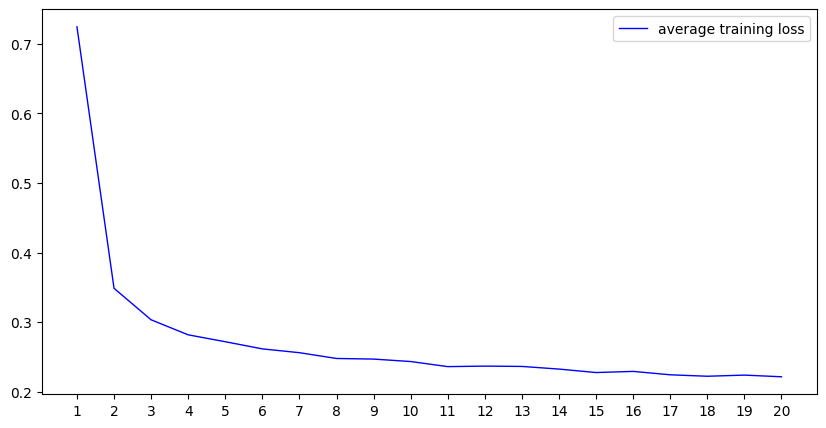

In [18]:
plt.figure(figsize=(10,5))
labels = [str(epoch + 1) for epoch in range(len(losses_avg))]
plt.plot(labels, losses_avg, '-b', label='average training loss', linewidth=1)
plt.legend(loc="upper right")
plt.show()

What about the actual model performance (i.e., accuracy for classification)? Well, the training accuracy should likewise mostly always increase assuming that the training loss is correlated with classification performance. However, the *validation* accuracy will plateau or even decrease. This is because the model is [overfitting](https://en.wikipedia.org/wiki/Overfitting) the finite training data and memorizing useless patterns that do not generalize.

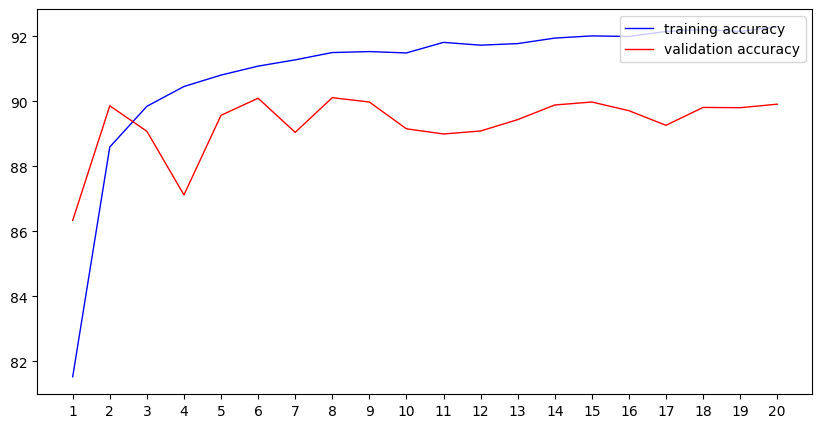

In [19]:
plt.figure(figsize=(10,5))
plt.plot(labels, accs_train, '-b', label='training accuracy', linewidth=1)
plt.plot(labels, accs_val, '-r', label='validation accuracy', linewidth=1)
plt.legend(loc="upper right")
plt.show()

Overfitting is a huge issue in machine learning. Strategies to prevent overfitting and improve generalization are called **regularization** methods. The full coverage of the deep connections between various regularization methods and a model's generalization capabilities is beyond the scope of this course. In practice, we often use a combination of different methods like

- **Early stopping**: Monitor validation performance and stop training if it doesn't improve for a certain number of epochs. This is the only explicit regularization we do in this assignment.
- **Weight penalty**: Instead of minimizing just $J(W, b)$, we minimize $J(W, b) + (\lambda/2) (\|W\|^2 + \|b\|^2)$ where $\lambda \geq 0$ controls the strength of regularization. There is hardly any change except that the gradient update becomes $W \gets W - \eta \nabla_W J(W, b) - \eta\lambda W$ (similarly for $b$), where you can see that we're "shrinking" the parameter size.
- **More training data**: This is obviously the best way to regularize (i.e., improve generalization), if you can afford to annotate more data.
- Other regularization techniques will be discussed later in the course (e.g., dropout).

# Hyperparameter Tuning

Experiments usually involve heavy hyperparameter tuning. This means you try a few different values of key hyperparameters to find one that works best (on validation data). For stochastic gradient descent, two important hyperparameters are the *batch size* and the *learning rate*. These two interact, so you have to search over their joint space. Typically you change them on a logarithmic scale (e.g., 0.0001, 0.001, 0.01, 0.1 for learning rates, 16, 32, 64, 128, 256 for batch sizes).

While we don't do this here, it is often more effective to do *random* search. For a certain number of trials, you'd draw a float $p$ from the uniform distribution over $[1,5]$ and set the learning rate to be $1\mathrm{e}{-p}$, similarly for batch size. This is particularly useful if the joint space of hyperparameters to tune is too large to search exhaustively.

The code below will take some time to run since we're performing *full training* for every pair (batch_size, learning_rate).

In [20]:
model_best = None
best_of_bests = float('-inf')
for batch_size in [128, 256, 512]:
  for learning_rate in [10, 1, 0.1]:
    model, best_acc_val, _, _, _ = train(batch_size, learning_rate, verbose=False)
    print('Batch size {:d}\t learning rate {:10.5f}\t acc val {:10.2f}'.format(
        batch_size, learning_rate, best_acc_val))
    if best_acc_val > best_of_bests:
      best_of_bests = best_acc_val
      model_best = copy.deepcopy(model)  # Saving the best performing model (validation performance)

Batch size 128	 learning rate   10.00000	 acc val      89.05
Batch size 128	 learning rate    1.00000	 acc val      90.33
Batch size 128	 learning rate    0.10000	 acc val      89.88
Batch size 256	 learning rate   10.00000	 acc val      89.58
Batch size 256	 learning rate    1.00000	 acc val      90.24
Batch size 256	 learning rate    0.10000	 acc val      89.23
Batch size 512	 learning rate   10.00000	 acc val      90.06
Batch size 512	 learning rate    1.00000	 acc val      90.19
Batch size 512	 learning rate    0.10000	 acc val      88.48


TODO: Fill the following minimal grid over batch sizes and learning rates with corresponding validation accuracies, and boldface the best one.


| batch_size\lr |   10  |   1   |  0.1  |
| :---:         | :---: | :---: | :---: |
| 128           | 89.05 | **90.33** | 89.88 |
| 256           | 89.58 | 90.24 | 89.23 |
| 512           | 90.06 | 90.19 | 88.48 |


Hyperparameter tuning may not be as exciting as implementing a model or deriving a formula, but it is absolutely an essential skill in modern NLP. Careful, well-thought-out tuning is key to good performance. This is not so much an issue for this simple model, but it becomes critical when the model gets complex.

# Error Analysis

Because we only have 4 labels we can easily visualize the prediction behavior of the model through a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

In [21]:
confusion_matrix = [[0 for _ in range(len(label2str))] for _ in range(len(label2str))]
N = 64
for i in range(0, X_val.shape[0], N):
  X = X_val[i: i + N]
  y = y_val[i: i + N]
  _, scores = model_best.forward(X)
  preds = np.argmax(scores, axis=1)[:, np.newaxis]
  for j in range(X.shape[0]):
    confusion_matrix[y[j][0]][preds[j][0]] += 1

for i in range(len(label2str)):
  num_label_i_total = sum(confusion_matrix[i])
  for j in range(len(label2str)):
    confusion_matrix[i][j] /= num_label_i_total

<Axes: >

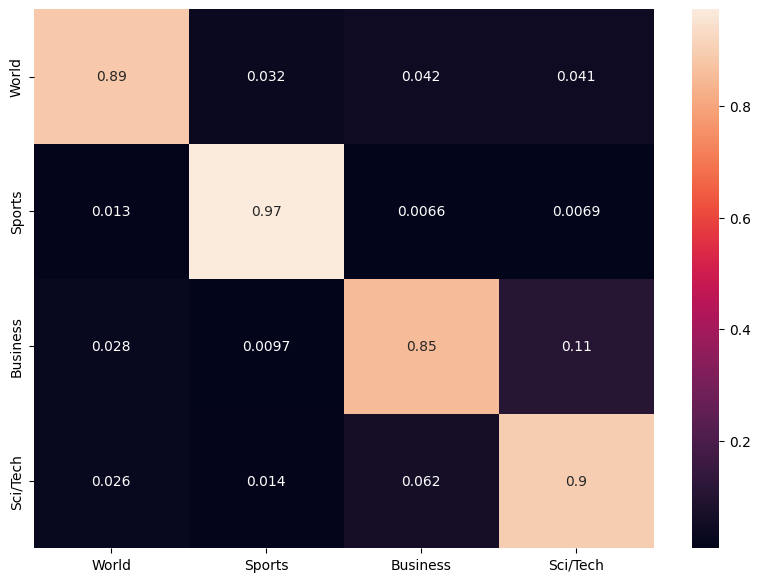

In [22]:
df_cm = pandas.DataFrame(confusion_matrix,
                         index=[label2str[i] for i in range(len(label2str))],
                         columns=[label2str[i] for i in range(len(label2str))])
plt.figure(figsize = (10,7))
seaborn.heatmap(df_cm, annot=True)

This is a relatively easy problem so we see that all the classes are mostly right. The model seems to predict Sci/Tech when the true label is Business. This is not surprising if you look at the data.

# Final Evaluation

The final performance to report is computed on the test portion using the best model from development (after tuning). Ideally the test portion should be touched only *once*, or as few times as possible.

In [23]:
acc_test = evaluate_accuracy(model_best, X_test, y_test)
print('Final test accuracy: {:10.2f}'.format(acc_test))

Final test accuracy:      90.36
